# Analysis

### Imports

In [1]:
import logging
from IPython.utils import io
from suite2p import run_s2p, default_ops

from logger import logger
from utils import loadtif, savetif, get_output_equivalent
from tifmerger import *
from stackviewers import view, dualview, plot_summary
from kalman import KalmanDenoiser

logger.setLevel(logging.INFO)

### Gather data folders

In [2]:
basedir = '../../data/raw/region1/'
datafolders = get_data_folders(basedir)

### Merge TIFs into stack

In [3]:
datafolder = datafolders[0]
with io.capture_output() as captured:  # turning off warning upon TIF reading
    stack_fpath = mergetifs(datafolder)

 11/10/2021 19:42:05: output stack file "/Users/tlemaire/Documents/data/stacked/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif" already exists
 11/10/2021 19:42:07: loaded (10, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/raw/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749_Cycle00001_Ch2_000001.ome.tif"
 11/10/2021 19:42:07: image 0 ("line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749_Cycle00001_Ch2_000001.ome.tif") is corrupted (shape = (10, 256, 256)) -> ommitting first 9 frames
 11/10/2021 19:42:08: generated 1600-frames image stack
 11/10/2021 19:42:08: saving (1600, 256, 256) uint16 stack as "/Users/tlemaire/Documents/data/stacked/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif"...


### Visualize stack

 11/10/2021 19:42:11: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/stacked/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif"
 11/10/2021 19:42:15: stack size: (1600, 256, 256)
 11/10/2021 19:42:15: rendering stack view...


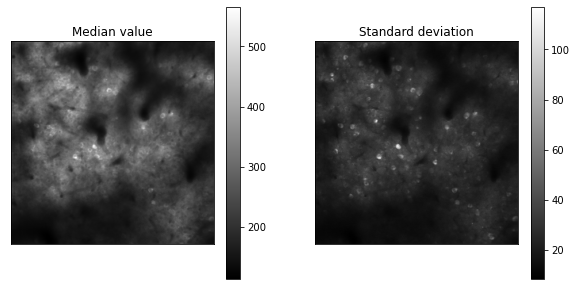

In [4]:
stack = loadtif(stack_fpath)
fig = plot_summary(stack)
view(stack)

### Apply Kalman filter to denoise stack

 11/10/2021 19:42:19: constructing 10-frames baseline from 1600-frames stack...
 11/10/2021 19:42:25: filtering 1600-frames stack with KalmanDenoiser(gain=0.8, var=0.05, npad=10)


100%|██████████| 1609/1609 [00:01<00:00, 1552.60it/s]


 11/10/2021 19:42:27: saving filtered stack in "/Users/tlemaire/Documents/data/filtered/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif"
 11/10/2021 19:42:27: saving (1600, 256, 256) uint16 stack as "/Users/tlemaire/Documents/data/filtered/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif"...
 11/10/2021 19:42:27: stack size: (1600, 256, 256)
 11/10/2021 19:42:27: rendering stacks view...


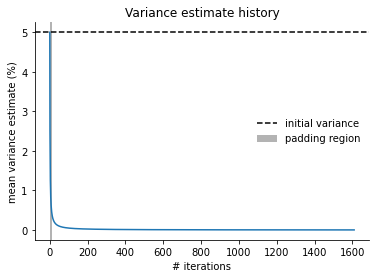

In [5]:
gain = 0.8
variance = 0.05
npad = 10
kd = KalmanDenoiser(gain=gain, variance=variance, npad=npad)
filtered_stack, ex_history = kd.filter(stack, full_output=True)
filtered_stack_fpath = get_output_equivalent(stack_fpath, 'stacked', 'filtered')
logger.info(f'saving filtered stack in "{filtered_stack_fpath}"')
savetif(filtered_stack_fpath, filtered_stack)
fig1 = kd.plot_variance_history(ex_history)
dualview(stack, filtered_stack, title1='Raw', title2='Filtered')

### Run suite2p

In [6]:
# Define input dataset
inputdir, _ = os.path.split(filtered_stack_fpath)
db = {'data_path': [inputdir]}

# Define run options
ops = default_ops()  # get default run options
myops = {
    'tau': 1.25,
    'fs': 3.56,
    'reg_tif': True,
    'nonrigid': True,
    'denoise': True,
    'nchannels': 1,
    'functional_chan': 1,
    #'diameter': 23, # perfect for mitral cells
    # 'align_by_chan': 2,
    # 'nchannels':  2,
    # 'functional_chan': 1,
    # 'spikedetect': True,
}
ops.update(myops)  # update with personal options
logger.info(f'Running suite 2P run options: \n {ops}')

# Run suite2p
ops_end = run_s2p(ops=ops, db=db)

 11/10/2021 19:42:43: Running suite 2P run options: 
 {'suite2p_version': '0.10.2', 'look_one_level_down': False, 'fast_disk': [], 'delete_bin': False, 'mesoscan': False, 'bruker': False, 'bruker_bidirectional': False, 'h5py': [], 'h5py_key': 'data', 'nwb_file': '', 'nwb_driver': '', 'nwb_series': '', 'save_path0': [], 'save_folder': [], 'subfolders': [], 'move_bin': False, 'nplanes': 1, 'nchannels': 1, 'functional_chan': 1, 'tau': 1.25, 'fs': 3.56, 'force_sktiff': False, 'frames_include': -1, 'multiplane_parallel': False, 'ignore_flyback': [], 'preclassify': 0.0, 'save_mat': False, 'save_NWB': False, 'combined': True, 'aspect': 1.0, 'do_bidiphase': False, 'bidiphase': 0, 'bidi_corrected': False, 'do_registration': 1, 'two_step_registration': False, 'keep_movie_raw': False, 'nimg_init': 300, 'batch_size': 500, 'maxregshift': 0.1, 'align_by_chan': 1, 'reg_tif': True, 'reg_tif_chan2': False, 'subpixel': 10, 'smooth_sigma_time': 0, 'smooth_sigma': 1.15, 'th_badframes': 1.0, 'norm_frames':

/opt/anaconda3/envs/suite2p/lib/python3.8/site-packages/suite2p/registration/utils.py:234: RuntimeWarning: invalid value encountered in apply_dotnorm
  return ifft2(apply_dotnorm(fft2(mov), img)) #.astype(np.complex64)


Reference frame, 5.08 sec.
Registered 1600/1600 in 17.47s
added enhanced mean image
----------- Total 24.45 sec


/opt/anaconda3/envs/suite2p/lib/python3.8/site-packages/suite2p/registration/utils.py:234: RuntimeWarning: invalid value encountered in apply_dotnorm
  return ifft2(apply_dotnorm(fft2(mov), img)) #.astype(np.complex64)


Registration metrics, 3.70 sec.
NOTE: Applying builtin classifier at /opt/anaconda3/envs/suite2p/lib/python3.8/site-packages/suite2p/classifiers/classifier.npy
----------- ROI DETECTION
Binning movie in chunks of length 04
Binned movie [375,254,254] in 0.24 sec.
Binned movie denoised (for cell detection only) in 2.25 sec.
NOTE: estimated spatial scale ~6 pixels, time epochs 1.00, threshold 5.00 
0 ROIs, score=148.65
1000 ROIs, score=13.32
2000 ROIs, score=7.16
Detected 2950 ROIs, 15.53 sec
After removing overlaps, 1384 ROIs remain
----------- Total 22.19 sec.
----------- EXTRACTION
Masks created, 1.08 sec.


/opt/anaconda3/envs/suite2p/lib/python3.8/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'cell_ipix' of function 'matmul_traces'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../opt/anaconda3/envs/suite2p/lib/python3.8/site-packages/suite2p/extraction/extract.py", line 105:
@njit(parallel=True)
def matmul_traces(Fi, data, cell_ipix, cell_lam):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/opt/anaconda3/envs/suite2p/lib/python3.8/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'cell_lam' of function 'matmul_traces'.

For more information visit https://numba.pydata.org/numba-doc/latest/

Extracted fluorescence from 1384 ROIs in 1600 frames, 3.98 sec.
----------- Total 5.18 sec.
----------- CLASSIFICATION
['npix_norm', 'skew', 'compact']
----------- Total 0.03 sec.
----------- SPIKE DECONVOLUTION
----------- Total 0.11 sec.
Plane 0 processed in 55.69 sec (can open in GUI).
total = 56.66 sec.
TOTAL RUNTIME 56.66 sec


### Check suite2p ouput

In [8]:
print(ops_end.keys())

dict_keys(['suite2p_version', 'look_one_level_down', 'fast_disk', 'delete_bin', 'mesoscan', 'bruker', 'bruker_bidirectional', 'h5py', 'h5py_key', 'nwb_file', 'nwb_driver', 'nwb_series', 'save_path0', 'save_folder', 'subfolders', 'move_bin', 'nplanes', 'nchannels', 'functional_chan', 'tau', 'fs', 'force_sktiff', 'frames_include', 'multiplane_parallel', 'ignore_flyback', 'preclassify', 'save_mat', 'save_NWB', 'combined', 'aspect', 'do_bidiphase', 'bidiphase', 'bidi_corrected', 'do_registration', 'two_step_registration', 'keep_movie_raw', 'nimg_init', 'batch_size', 'maxregshift', 'align_by_chan', 'reg_tif', 'reg_tif_chan2', 'subpixel', 'smooth_sigma_time', 'smooth_sigma', 'th_badframes', 'norm_frames', 'force_refImg', 'pad_fft', 'nonrigid', 'block_size', 'snr_thresh', 'maxregshiftNR', '1Preg', 'spatial_hp', 'spatial_hp_reg', 'spatial_hp_detect', 'pre_smooth', 'spatial_taper', 'roidetect', 'spikedetect', 'anatomical_only', 'cellprob_threshold', 'flow_threshold', 'sparse_mode', 'diameter', 